# Agent Development

In [10]:
from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI

# from core import get_model, settings

import os
from dotenv import load_dotenv
load_dotenv()

# Access API keys and credentials
OPENAI_API_KEY    = os.environ["OPENAI_API_KEY"]
GEMINI_API_KEY    = os.environ["GEMINI_API_KEY"]
# TIMESCALE_DB_URI  = os.environ["TIMESCALE_DB_URI"]
# MAIN_AGENT_DB_URI = os.environ["MAIN_AGENT_DB_URI"]
# TAVILY_API_KEY    = os.environ["TAVILY_API_KEY"]




class AgentState(MessagesState, total=False):
    """`total=False` marks fields added here as optional (PEP 589),
    while inherited fields (like `messages` from MessagesState) keep their original requirements.

    documentation: https://typing.readthedocs.io/en/latest/spec/typeddict.html#totality
    """
    # # Safety metadata from LlamaGuard (populated by guard nodes)
    # safety: LlamaGuardOutput

    # # LangGraph-managed remaining step budget for the current run
    # remaining_steps: RemainingSteps


MODEL_SYSTEM_MESSAGE = """ You are a helpful chatbot ...

<context>
{context}
</context>
"""


context = 'context'


async def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    """Main model node:
       - Selects the concrete model (from config or default),
       - Runs the tool-enabled chat model,
       - Post-checks the output with LlamaGuard,
       - Enforces step budget if tool calls remain."""
    
    # # can later decide to pace it outside the fn, if observed high latency in traces
    # model      = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))
    # model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0, max_tokens=1000)

    # latency is way lower than openai
    model = ChatGoogleGenerativeAI(
        model       = "gemini-2.0-flash-lite",
        api_key     = GEMINI_API_KEY,          # make it of tyoe secret key when wrapping in fastapi
        temperature = 0,
        max_tokens  = 1000
    )

    
    system_msg = MODEL_SYSTEM_MESSAGE.format(context=context)
    response   = await model.ainvoke(
                                        [SystemMessage(content=system_msg)] + state["messages"],
                                        config=config
                                    )
    
    return {"messages": [response]}

# -------------------------
# BUILD THE GRAPH
# -------------------------

builder = StateGraph(AgentState)

builder.add_node("acall_model", acall_model)
builder.set_entry_point("acall_model")
builder.add_edge('acall_model', END)

# Compile with an in-memory checkpointer; resume by calling invoke() on the same thread_id
checkpointer = MemorySaver()

# Compile the graph with persistent checkpointer and in-memory store
graph = builder.compile(checkpointer=checkpointer)# store=across_thread_memory)

    

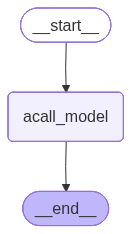

In [11]:
from IPython.display import Image, display
# View
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph().draw_ascii(), '\n\n')
    print(graph.get_graph().draw_mermaid())


In [12]:
cfg = {"configurable": {"user_id":'1', "thread_id": '1'}}

text=HumanMessage(content='what was my name?')
# Kick off (provide initial state once)
output = await graph.ainvoke({"messages": [text]}, cfg)
for msg in output['messages']:
    msg.pretty_print()


================================ Human Message =================================

what was my name?
================================== Ai Message ==================================

I do not have access to your name. I am a language model, and I do not retain information from previous conversations.
